# Grover's Algorithm 

This Jupyter Notebook contains an implementation of Grover's algorithm.
Grover's algorithm is used to obtain a quadratic speed-up in database search problems, but it can have many other applications as its amplitude amplification trick can help speeding up other quantum algorithms.

For a classical computer, finding an element in a list of $N$ items requires to check on average $N/2$ elements, and in the worst case, all $N$ of them. Using Grover algorithm, however, the wanted item can be found only in roughly $\sqrt{N}$ steps.

Additionally, the algorithm does not use the list's internal structure, which makes it generic and easy to apply to a wide set of problems.
$\newcommand{\ket}[1]{\left|{#1}\right\rangle}$
$\newcommand{\bra}[1]{\left\langle{#1}\right|}$

## Prerequisites
* Suppose the database contains $N$ items, among which only $0 \le M \le N$ are solutions to our search problem.
    * Items are identified by their index, an integer that goes from $0$ to $N-1$. As a result, only $n$ qubits are needed, where $2^n = N$.
    * We will assume that $M$ is known. If that is not the case, an additional step of counting the number of solutions must be run before the Grover search.
* Suppose we can build a classical function $f(x)$, capable of checking whether item $x$ is a solution or not. This is an abstract function, whose implementation stricty depends on the actual problem. We will assume in general terms that the function return $1$ if $x$ is a solution and $0$ otherwise.
$$ f(x) = \begin{cases}1, \quad \text{if x is a solution}\\0, \quad \text{otherwise}\end{cases}$$

## Procedure
The main idea behind the algorithm is that of "amplitude amplification": you start from a uniform superposition of all quantum states, each of them representing an item, and then increasing the amplitude of the "solution" states so that measuring the qubits at the end returns with high probabily one solution to the problem.

The amplification procedure can be divided into two steps: first, the solution states need to be marked with a phase flip using an oracle based on $f(x)$; then the flipped states are enhanced by reflecting the superposition away from the non-flipped states using the "Grover diffuser" operator.

1. Build the uniform superposition of states.
$$ \ket{s} = \frac{1}{\sqrt{N}} \sum_{x=0}^{N-1} \ket{x}$$
$\ket{s}$ can be seen in the two-dimensional complex plane spanned by the solution states $\ket{w}$ and the non-solution states $\ket{s'}$.
$$ \ket{w} = \frac{1}{\sqrt{M}}\sum^{\text{sol}}\ket{x} \qquad \ket{s'} = \frac{1}{\sqrt{N-M}}\sum^{\text{non-sol}}\ket{x}$$
We can then define $\theta$ as the angle between $\ket{s}$ and $\ket{s'}$:
$$ \ket{s} = \sqrt{\frac{M}{N}} \ket{w} + \sqrt{\frac{N-M}{N}}\ket{s'} = \sin \theta \ket{w} + \cos \theta \ket{s'} $$
![step1](images/grover_step1.jpg)

2. Build an oracle $U_f$ using $f(x)$ so that:
$$ U_f \ket{x} = (-1)^{f(x)}|x> $$
Applying $U_f$ to $\ket{s}$, only the component along $\ket{w}$ acquires a phase flip. In this two dimensional plane, this corresponds to a reflection of the state $\ket{s}$ with respect of $\ket{s'}$.
![step2](images/grover_step2.jpg)

3. Build a diffuser $U_s$ to reflect with respect to $\ket{s}$:
$$ U_s = 2\ket{s}\bra{s} - Id $$
The resulting state $U_s U_f \ket{s}$ lies closer to $\ket{w}$ than before: this means that the process has increased the relative amplitude of the solution states in the superposition! 
![step2](images/grover_step3.jpg)

4. Repeat the steps on $\ket{s}$ several time.
We define the Grover operator as $U_G = U_f U_s$. Each application of $U_G$ moves $\ket{s}$ closer to $\ket{w}$ by $2\theta$. So, after applying it $t$ times, we get:
$$\theta_t = (2t+1)\theta_0 \quad \text{where} \quad \sin\theta_0 = \sqrt{\frac{M}{N}} $$
Assuming $M \ll N$, $\theta_0 \sim \sqrt{\frac{M}{N}}$. Moreover, we want $\theta_t \sim \frac{\pi}{2}$ in order to be close to $\ket{w}$. The number of iteration required are then:
$$ t = \frac{1}{2}\left(\frac{\pi}{2}\sqrt{\frac{N}{M}}-1\right) \sim \frac{\pi}{4}\sqrt{\frac{N}{M}}$$

## Step-by-step
Let's follow the algorithm step by step, using qiskit to create a quantum circuit that implements the algorithm.

In [1]:
# import matplotlib, numpy
import matplotlib.pyplot as plt
import numpy as np

# import Qiskit
from qiskit import IBMQ, Aer, assemble, transpile
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.circuit import classical_function, Int1
from qiskit.providers.ibmq import least_busy

# import basic plot tools
from qiskit.visualization import plot_histogram

Let's suppose to have $N=16$. Let's also assume that there are $M=2$ solutions to the problem.

This requires the use of $n=4$ qubits to represent all 16 items, plus an additional ancilla qubit that is needed by the oracle function.

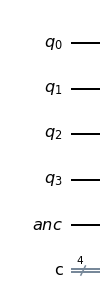

In [2]:
N = 16
n = int(np.log2(N))

qr = QuantumRegister(n,"q")
anc = QuantumRegister(1,"anc")
cr = ClassicalRegister(n,"c")

grover_circuit = QuantumCircuit(qr,anc,cr)
grover_circuit.draw(output="mpl")

### Step 1: Initialization
The first step of the algorithm is to initialize the $n$ qubits, assumed to be in the $\ket{00\dots0}$ state, in the uniform superposition of all possible states of the system, which we will call $\ket{s}$.
$$ \ket{s} = \frac{1}{\sqrt{N}} \sum_{x=0}^{N-1} \ket{x}$$
This can be achieved by applying an Hadamard gate to each qubit:
$$ \ket{s} = H^{\otimes n} \ket{00\dots0}$$

In [3]:
def initialize_s(circuit, qubits):
    """Apply a H-gate to 'qubits' in circuit"""
    for q in qubits:
        circuit.h(q)
    return circuit

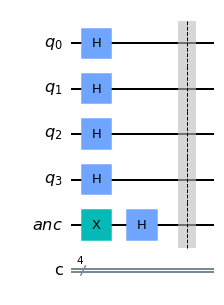

In [4]:
grover_circuit = initialize_s(grover_circuit, range(n))

# setup the ancillary qubit
grover_circuit.x(n) # |0> -> |1>
grover_circuit.h(n) # |1> -> |->

grover_circuit.barrier()
grover_circuit.draw(output="mpl")

### Step 2: Building the Oracle
The oracle is a black box that adds an overall phase to the quantum states that solve the problem. It is defined using the classical function $f(x)$ which is able to verify a solution. In particular, the overall effect is:
$$ U_w \ket{x} = (-1)^{f(x)}|x> $$
This gate is built using an additional ancilla qubit $\ket{q}$ and performing the modulo-2 sum of the two:
$$ \ket{x,q} \longrightarrow \ket{x, q \oplus f(x)} $$
if the ancilla qubit is initilized as $\ket{q} = \ket{-} = \frac{1}{\sqrt{2}}\left(\ket{0}-\ket{1}\right)$, it can be shown by direct computation that:
$$ \ket{x,-} \longrightarrow (-1)^{f(x)}\ket{x, -} $$
so ignoring from the results the ancilla qubit, we get exaclty the required oracle.

$f(x)$ is a classical function. For this example, it returns $1$ for the two solutions $0011$ and $0101$.

In [5]:
# define a classical function f(x): this returns 1 for the solutions of the problem
# in this case, the solutions are 1010 and 1100
@classical_function
def f(x1: Int1, x2: Int1, x3: Int1, x4: Int1) -> Int1:
    return (x1 and not x2 and x3 and not x4) or (x1 and x2 and not x3 and not x4)

def oracle(nqubits):
    
    Uf = f.synth()  # turn it into a circuit
    oracle = QuantumCircuit(nqubits+1)
    oracle.compose(Uf, inplace=True)

    # We will return the diffuser as a gate
    U_f = oracle.to_gate()
    U_f.name = "U$_f$"
    return U_f

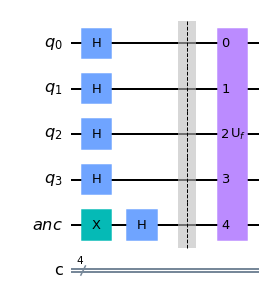

In [6]:
grover_circuit.append(oracle(n),range(n+1))
grover_circuit.draw(output="mpl")

### Step 3: Building the Grover diffuser
The Grover diffuser is described in abstract terms as:
$$ U_s = 2\ket{s}\bra{s} - Id $$
This can be shown to be equivalent to another set of operators, following from $\ket{s} = H^{\otimes n} \ket{00\dots0}$ and $H^{\otimes n}H^{\otimes n}=Id$:
$$ U_s = H^{\otimes n} U_0 H^{\otimes n}$$
where $U_0 = 2\ket{00\dots0}\bra{00\dots0} - Id$ is an operator that applies a phase flip to all states, except for $\ket{00\dots0}$.

$U_0$ can be more easily constructed by applying $X$-gates and a multi-controlled $Z$ gate. In particular, a multi-controlled $Z$ gate flips the phase of $\ket{1\dots11}$:
$$ MCZ = 
\begin{bmatrix}
 1 & 0 & 0 & \cdots & 0 \\
 0 & 1 & 0 & \cdots & 0 \\
 \vdots & \vdots & \vdots & \ddots & \vdots \\
 0 & 0 & 0 & \cdots & -1 \\
\end{bmatrix} $$
Applying an $X$-gate to each qubit performs the transformation:
\begin{aligned}
|00\dots 0\rangle & \rightarrow |11\dots 1\rangle\\
|11\dots 1\rangle & \rightarrow |00\dots 0\rangle
\end{aligned}
Therefore:
$$ U_0 = - X^{\otimes n} MCZ X^{\otimes n} $$
Since the overall phase is not importante, we can simply ignore the $-1$ in front. The result is that the Grover diffuser can be built as:
$$U_s = H^{\otimes n} X^{\otimes n} (MCZ) X^{\otimes n} H^{\otimes n} $$
![diffuser](images/diffuser.png)

#### Note #####
Just as the $CNOT$ applies an $X$ to its target qubit whenever its control is in state $\ket{1}$, the controlled-$Z$ applies a $Z$ in the same case. Given that $H X H = Z$, we can use this trick to to transform a multi-$CNOT$ into a multi-controlled-$Z$. All we need to do is precede and follow the multi-$CNOT$ with a Hadamard on the target qubit. This will transform any $X$ applied to that qubit into a $Z$.

In [7]:
def diffuser(nqubits):
    qc = QuantumCircuit(nqubits)
    # Apply transformation |s> -> |00..0> (H-gates)
    for qubit in range(nqubits):
        qc.h(qubit)
    # Apply transformation |00..0> -> |11..1> (X-gates)
    for qubit in range(nqubits):
        qc.x(qubit)
    # Do multi-controlled-Z gate
    qc.h(nqubits-1)
    qc.mct(list(range(nqubits-1)), nqubits-1)  # multi-controlled-toffoli
    qc.h(nqubits-1)
    # Apply transformation |11..1> -> |00..0>
    for qubit in range(nqubits):
        qc.x(qubit)
    # Apply transformation |00..0> -> |s>
    for qubit in range(nqubits):
        qc.h(qubit)
    # We will return the diffuser as a gate
    U_s = qc.to_gate()
    U_s.name = "U$_s$"
    return U_s

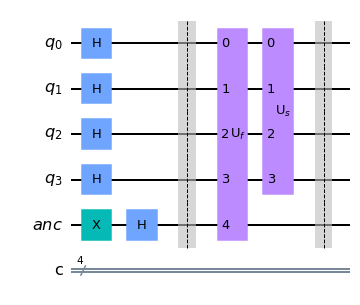

In [8]:
# Diffusion operator (U_s)
grover_circuit.append(diffuser(n),range(n))
grover_circuit.barrier()
grover_circuit.draw(output="mpl")

### Step 4: Apply and repeat
Given that $N=16$ and $M=2$, $t \sim 2 $ iterations of the algorithm are needed.

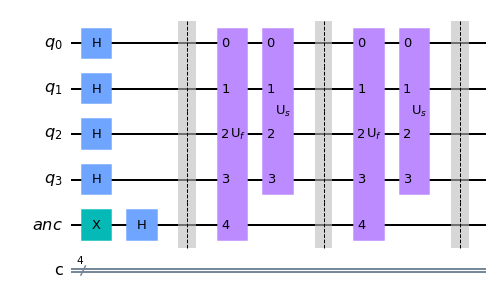

In [9]:
grover_circuit.append(oracle(n),range(n+1))
grover_circuit.append(diffuser(n),range(n))
grover_circuit.barrier()
grover_circuit.draw(output="mpl")

## Results
We measure all qubits at the same time, simulating the circuit to get the probabilities of measuring each state. As expected, we find the two solutions marked by the oracle ($\ket{0011}$ and $\ket{0101}$) having probabilities close to $50\%$

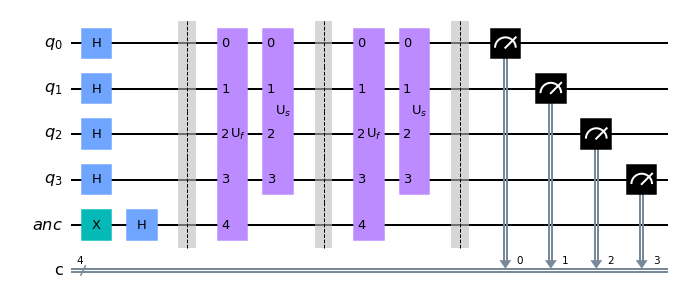

In [10]:
grover_circuit.measure(qr,cr)
grover_circuit.draw(output="mpl")

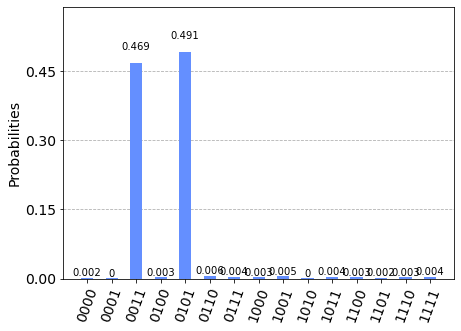

In [11]:
aer_sim = Aer.get_backend('aer_simulator')
transpiled_grover_circuit = transpile(grover_circuit, aer_sim)
qobj = assemble(transpiled_grover_circuit)
results = aer_sim.run(qobj).result()
counts = results.get_counts()
plot_histogram(counts)

### Real Quantum device
Let's now try to run this code on an actual quantum device at IBM.

In [12]:
# Load IBM Q account and get the least busy backend device
provider = IBMQ.load_account()
provider = IBMQ.get_provider("ibm-q")
device = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= 3 and 
                                   not x.configuration().simulator and x.status().operational==True))
print("Running on current least busy device: ", device)

Running on current least busy device:  ibmq_belem


In [13]:
# Run our circuit on the least busy backend. Monitor the execution of the job in the queue
from qiskit.tools.monitor import job_monitor
transpiled_grover_circuit = transpile(grover_circuit, device, optimization_level=3)
job = device.run(transpiled_grover_circuit)
job_monitor(job, interval=2)

Job Status: job has successfully run


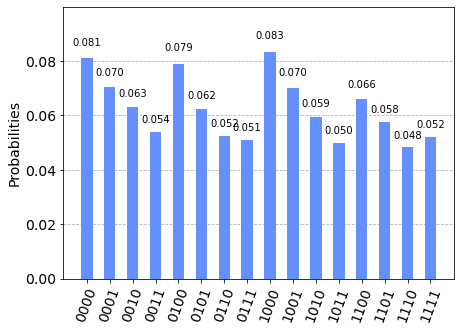

In [14]:
# Get the results from the computation
results = job.result()
answer = results.get_counts(grover_circuit)
plot_histogram(answer)